In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load Data

In [6]:

from datetime import timedelta

#  Connect to your database
conn = sqlite3.connect("/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/mlb/mlb_players.db")

# 🔍 Load tables
injuries = pd.read_sql_query("SELECT * FROM injury_stats", conn)
stats = pd.read_sql_query("SELECT * FROM mlb_player_stats", conn)

# 🕒 Convert dates
injuries['injury_date'] = pd.to_datetime(injuries['injury_date'], errors='coerce')
stats['game_date'] = pd.to_datetime(stats['game_date'], errors='coerce')
stats = stats.dropna(subset=['game_date'])

# 📊 Get injury stats (last 10 days before injury)
injured_rows = []
for _, injury in injuries.iterrows():
    player_id = injury['mlb_player_id']
    injury_date = injury['injury_date']

    window = stats[
        (stats['mlb_player_id'] == player_id) &
        (stats['game_date'] >= injury_date - timedelta(days=10)) &
        (stats['game_date'] < injury_date)
    ].copy()

    if not window.empty:
        window['injured'] = 1
        injured_rows.append(window)

injured_df = pd.concat(injured_rows, ignore_index=True)

# 🧼 Remove duplicates and overlap from healthy pool
injured_ids = set(injured_df['mlb_player_id'].unique())
healthy_df = stats[~stats['mlb_player_id'].isin(injured_ids)].copy()

# Use most recent 10 days of data (you can modify this)
latest_date = healthy_df['game_date'].max()
healthy_df = healthy_df[healthy_df['game_date'] >= latest_date - timedelta(days=10)]
healthy_df['injured'] = 0

# 🧬 Combine
combined_df = pd.concat([injured_df, healthy_df], ignore_index=True)
print("✅ Combined shape:", combined_df.shape)

# 💾 Optional: Save it
#combined_df.to_csv("data/labeled_player_stats.csv", index=False)

✅ Combined shape: (15787, 73)


In [14]:
df = combined_df.copy()
print("🔹 Loaded data shape:", df.shape)

🔹 Loaded data shape: (15787, 73)


## Processing   

In [ ]:
# Drop identifier or non-useful columns
drop_cols = [
    'game_date', 'season', 'game_id', 'summary', 'StatType', 'StatGroup',
    'Team', 'Opponent', 'Position', 'Games', 'PlayerID', 'TeamID', 'OpponentID'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
print("🔹 After dropping:", df.shape)

# Fill missing values (can also use imputation)
df = df.fillna(0)



🔹 After dropping: (15787, 69)


/var/folders/cw/3rv8y44572g92cpbrwppsy8h0000gn/T/ipykernel_38003/884020710.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


/var/folders/cw/3rv8y44572g92cpbrwppsy8h0000gn/T/ipykernel_38003/481208676.py:15: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


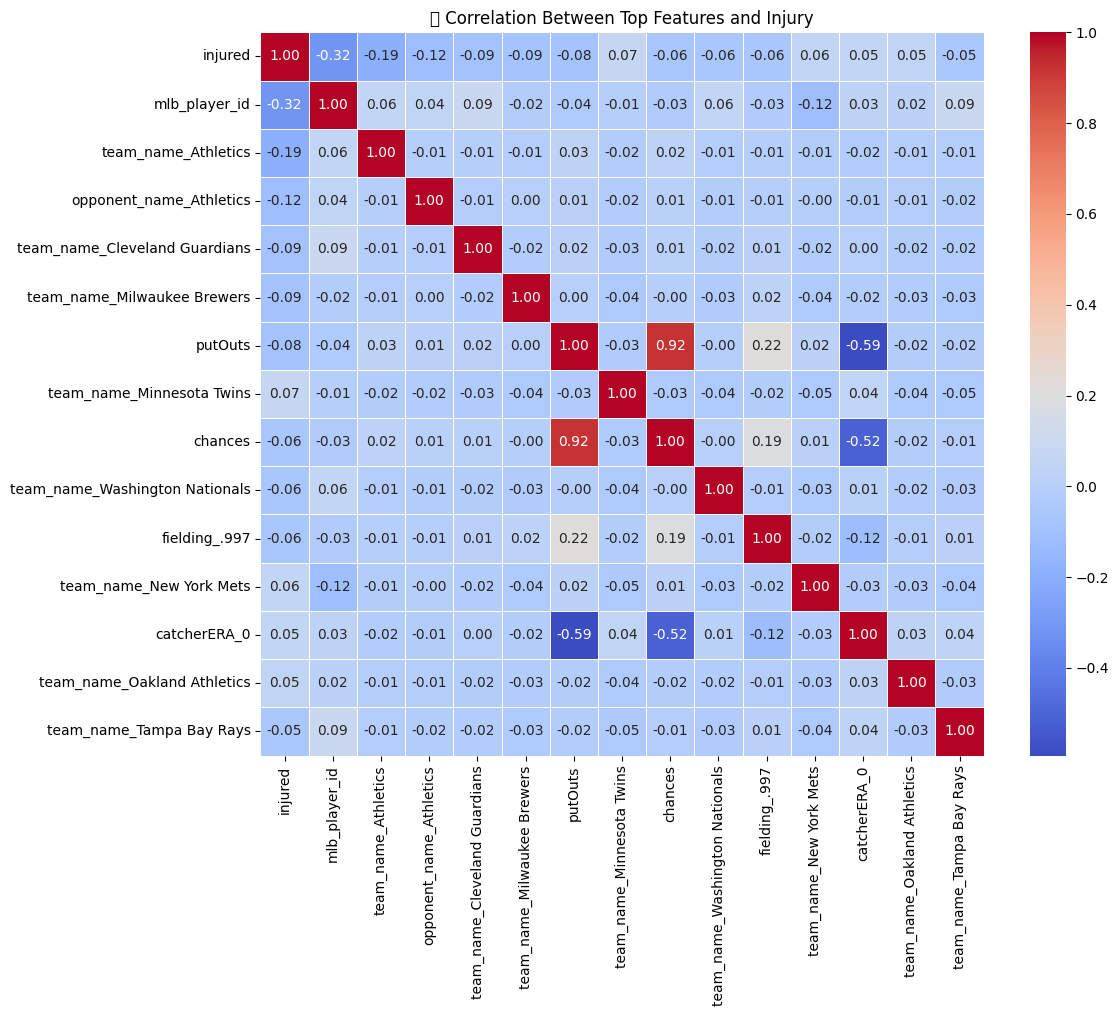

In [16]:
df = pd.get_dummies(df)

# Make sure 'injured' column exists
if 'injured' not in df.columns:
    raise ValueError("🛑 'injured' column not found")

# 🔗 Plot correlation
corr_matrix = df.corr(numeric_only=True)
top_features = corr_matrix['injured'].abs().sort_values(ascending=False).head(15).index
corr_subset = corr_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("🔗 Correlation Between Top Features and Injury")
plt.tight_layout()
plt.show()

In [17]:
X = df.drop(columns='injured')
y = df['injured']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Training samples:", len(X_train))
print("✅ Test samples:", len(X_test))

✅ Training samples: 12629
✅ Test samples: 3158


In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred = model.predict(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60       355
           1       0.93      1.00      0.97      2803

    accuracy                           0.94      3158
   macro avg       0.96      0.72      0.78      3158
weighted avg       0.94      0.94      0.92      3158



/var/folders/cw/3rv8y44572g92cpbrwppsy8h0000gn/T/ipykernel_38003/3816374431.py:9: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


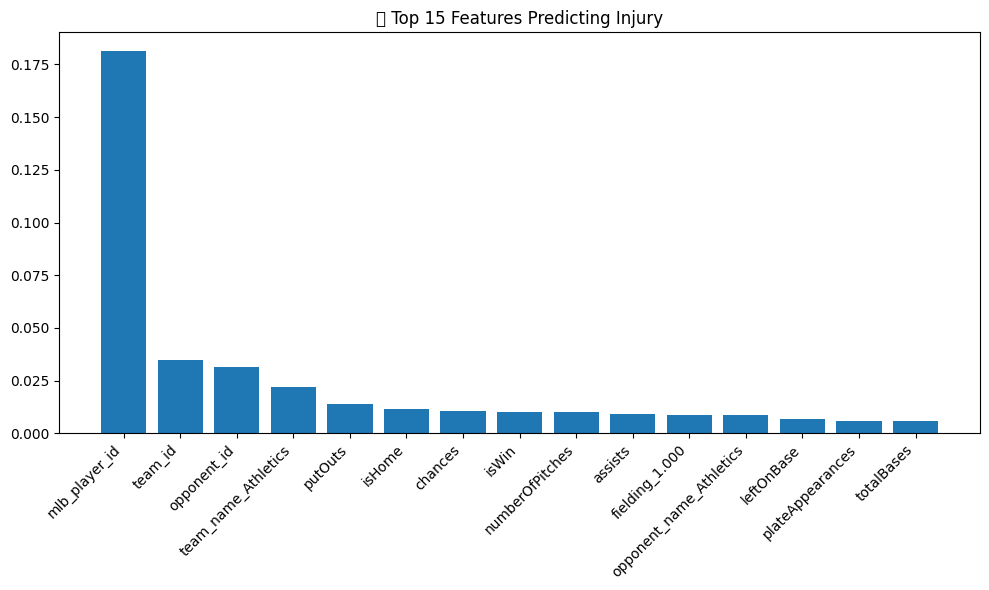

In [20]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
plt.title("📌 Top 15 Features Predicting Injury")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()